# K-fold Cross-Validation

## Implementing 5-fold cross-validation for logistic regression.

### Setup:
1.  Upload API_Demo_3.afm into your API Demo workspace.
1.  Open the workflow and configure the data set to point to the location of your dataset in HDFS.
1.  Run the workflow through the Alpine UI to make sure that everything is configured correctly.

### Please change the values in the following cell as necessary.


In [1]:
username = "apidemo"
password = "apidemo"
alpine_base_url = "http://10.0.0.206:8080"
workflow_id = 523

### Again, I will copy some useful functions from demos 1 and 2.

In [2]:
import requests
import json
from pprint import pprint
import time
from IPython.display import Image
import matplotlib.pyplot as plt
%matplotlib inline

start_index = alpine_base_url.find("://") + 3
host_info = alpine_base_url[start_index:]

alpine_session = requests.Session()
alpine_session.headers.update({"Host": host_info})

In [3]:
def login():
    token = ""
    
    login_url = alpine_base_url + "/sessions?session_id=NULL"
    body = {"username": username, "password": password}
    login_response = alpine_session.post(login_url, data=body)
    
    if login_response.status_code == 201:
        token = login_response.json()['response']['session_id']
    
    return token


def get_workflow_status(pid, sid):
    
    query_url = alpine_base_url + "/alpinedatalabs/api/v1/json/processes/" + str(pid) + "/query"
    alpine_session.headers.update({"x-token": sid})
    alpine_session.headers.update({"Content-Type": "application/json"})
    
    status_response = alpine_session.get(query_url, timeout=60)
    
    in_progress_states = ["IN_PROGRESS", "NODE_STARTED", "STARTED", "NODE_FINISHED"]
    if status_response.status_code == 200:
        try:
            if status_response.json()['meta']['state'] in in_progress_states:
                return "WORKING"
        except ValueError:
            if status_response.text == 'Workflow not started or already stopped.\n' or resp.text == "invalid processId or workflow already stopped.\n":
                return "FINISHED"
            else:
                return "FAILED"
    else:
        raise Exception("Workflow failed with status {0}: {1}".format(status_response.status_code, status_response.reason))
        
        
def wait_for_workflow_to_finish(sid, wid, pid, wait_time=5):
    
    time_elapsed = 0
    start_time = time.time()
    
    while get_workflow_status(pid, sid) == "WORKING":
            
            time_elapsed = time.time() - start_time
            print("\rWorkflow in progress for ~{0:.1f} seconds.".format(time_elapsed)),
            time.sleep(wait_time)
                
    print("\rWorkflow finished in ~{0:.1f} seconds.".format(time_elapsed))

    
def get_workflow_results(wid, pid):
    result_url = alpine_base_url + "/alpinedatalabs/api/v1/json/workflows/" + str(workflow_id) + "/results/" + str(process_id)
    response = alpine_session.get(result_url)
    return response


def find_operator(name, oper_list):
    for oper in oper_list:
        if oper['out_title'] == name:
            return oper
    return []


def run_workflow_with_variables(wid, wf_var):
    alpine_session.headers.update({"x-token": session_id})
    run_url = alpine_base_url + "/alpinedatalabs/api/v1/json/workflows/" + str(workflow_id) + "/run" + "?saveResult=true"
    alpine_session.headers.update({"Content-Type": "application/json"})
    run_response = alpine_session.post(run_url, data=wf_var, timeout=1000)

    process_id = run_response.json()['meta']['processId']
    return process_id

In [4]:
session_id = login()
print(session_id)

9d7324928867d56ef92d40c5106b0b2e8e27faa2


### Let's put all of this together and run a more complicated workflow, one that is set up to do a 5-fold cross-validation.  Open the workflow API Demo 3.  Just like before, set up the workflow to accept a workflow variable called @lambda with default value 0.  Also add this parameter to each Logistic Regression operator and save the workflow.

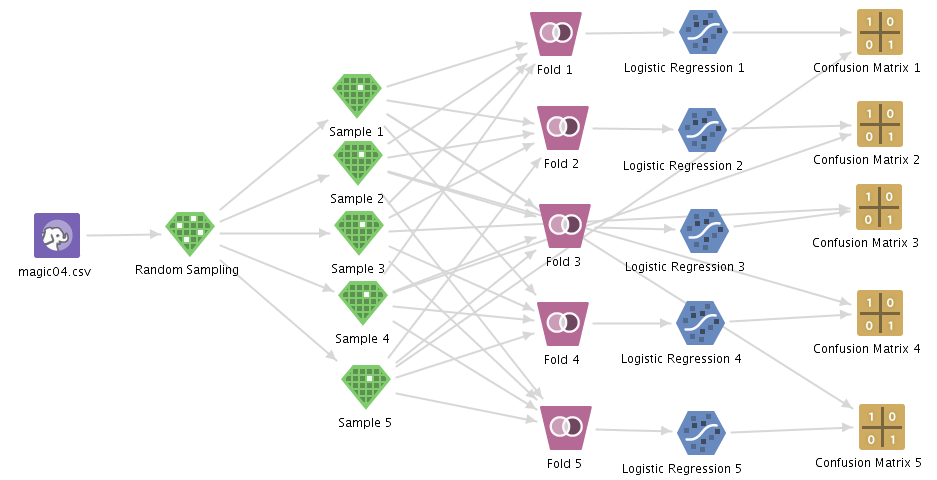

In [5]:
Image(filename='Images/Demo3.png')

### Let's run the workflow once with a regularization parameter = 0.

In [6]:
workflow_variables='{"meta":{"version":1}, "variables":[{"name":"@lambda", "value":"0"}]}'

process_id = run_workflow_with_variables(workflow_id, workflow_variables)
wait_for_workflow_to_finish(session_id, workflow_id, process_id)

Workflow finished in ~507.4 seconds.


In [8]:
workflow_result = get_workflow_results(workflow_id, process_id)
result = json.loads(workflow_result.json())
operator_list = result['outputs']
len(operator_list)

22

### Calculating accuracy for 5-fold cross-validation is a little more complicated.  We need to find the average accuracy for all five confusion matricies, wieghted by the number of samples.

In [33]:
def find_accuracy_and_Nsamples_from_COM_operator(operator_data):
    try:
        accuracy = operator_data['visualData'][1]['visualData']['heatMapTable']['accuracy']
        Nsamples = int(operator_data['visualData'][0]['visualData']['items'][0]['Predicted (0)']) + \
            int(operator_data['visualData'][0]['visualData']['items'][0]['Predicted (1)']) + \
            int(operator_data['visualData'][0]['visualData']['items'][1]['Predicted (0)']) + \
            int(operator_data['visualData'][0]['visualData']['items'][1]['Predicted (1)'])
        return (accuracy, Nsamples)
    except:
        print("You probably didn't pass a confusion matrix operator")
        return (0,0)
                
def calculate_average_accuracy(confusion_op_names, op_list):
    running_acc_total = 0.0
    running_sample_total = 0
    
    for name in confusion_op_names:
        oper_data = find_operator(name, op_list)
        (acc, N) = find_accuracy_and_Nsamples_from_COM_operator(oper_data)
        running_acc_total += acc*N
        running_sample_total += N

    return running_acc_total/running_sample_total;

In [34]:
base_op_name = 'Confusion Matrix '
index = range(1,6)
COM_list = [base_op_name+str(i) for i in index]

average_accuracy = 100*calculate_average_accuracy(COM_list, operator_list)
print("Accuracy = {0:.1f}%".format(average_accuracy))

Accuracy = 78.8%


### Now we are ready to do some 5-fold cross-validation to help us tune the hyperparameter lambda.  Let's run the workflow for a small list of lambda values and calculate the accuracy for each run.  Note that the *Random Sampling* operator is set to always give the same 5 samples each time we run the workflow.  We can get different samples by changing the random seed or turning off consistent samples.

### The next cell will take a long time to run completely.  For reference, I've included the output in the following cell.

In [35]:
lambda_list = [0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.04, 0.05, 0.07, 0.09, 0.1, 0.25, 0.5, 1]

average_accuracy_list = [0 for item in lambda_list]

print("--------------------------------------------------------")

for index, value in enumerate(lambda_list):
    print("Running workflow with lambda = {}".format(value))
    workflow_variables='{"meta":{"version":1}, "variables":[{"name":"@lambda", "value":"{}"}]}'.replace("{}", str(value))

    process_id = run_workflow_with_variables(workflow_id, workflow_variables)
    wait_for_workflow_to_finish(session_id, workflow_id, process_id)
    workflow_result = get_workflow_results(workflow_id, process_id)

    result = json.loads(workflow_result.json())
    operator_list = result['outputs']
    
    average_accuracy = 100*calculate_average_accuracy(COM_list, operator_list)
    print("Accuracy = {0:.1f}%".format(average_accuracy))
    print("--------------------------------------------------------")

    average_accuracy_list[index] = average_accuracy

--------------------------------------------------------
Running workflow with lambda = 0
Workflow finished in ~150.9 seconds.
Accuracy = 78.8%
--------------------------------------------------------
Running workflow with lambda = 0.005
Workflow finished in ~161.0 seconds.
Accuracy = 78.9%
--------------------------------------------------------
Running workflow with lambda = 0.01
Workflow finished in ~151.0 seconds.
Accuracy = 78.7%
--------------------------------------------------------
Running workflow with lambda = 0.015
Workflow finished in ~161.0 seconds.
Accuracy = 78.5%
--------------------------------------------------------
Running workflow with lambda = 0.02
Workflow finished in ~161.1 seconds.
Accuracy = 78.4%
--------------------------------------------------------
Running workflow with lambda = 0.025
Workflow finished in ~161.1 seconds.
Accuracy = 78.3%
--------------------------------------------------------
Running workflow with lambda = 0.03
Workflow finished in ~156

In [25]:
# reference values:
#average_accuracy_list = [78.90044499091398, 78.8367652748831, 78.85799134670866, 78.96412681227555, 78.98535334464218, 79.02780835655332, 79.0278085387454, 79.07026263843092, 79.09148961489075, 79.09148961489075, 79.07026225759887, 79.07026225759887, 79.02780834010542, 79.02780799090394, 78.94290144138341]
#lambda_list = [0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.04, 0.05, 0.07, 0.09, 0.1, 0.25, 0.5, 1]

### Now let's plot the prediction accuracy as a function of the penalization parameter.  Ideally, we'll see that at some intermediate value, the accuracy is maximized.

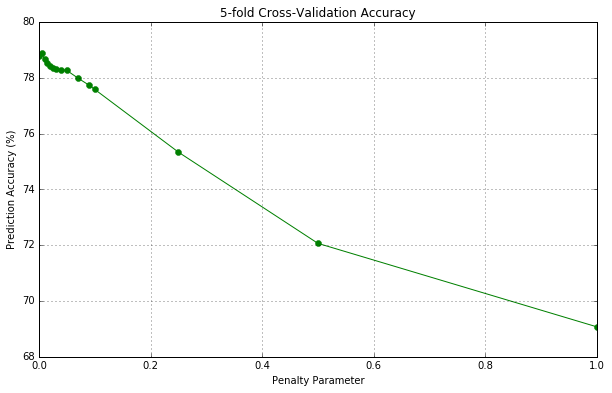

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(lambda_list, average_accuracy_list, "g.-", markersize = 12)
plt.xlabel("Penalty Parameter")
plt.ylabel("Prediction Accuracy (%)")
plt.title("5-fold Cross-Validation Accuracy")
plt.grid()
plt.show()